# Positive Only Sparse Coding on MNIST

This code implements Positive Only Sparse Coding on MNIST.

Lets break that down.

Sparse Coding is an algorithm that seeks to disentangle the underlying generative factors of data. In this particular case, we are considering the dataset, MNIST, which is a collection of digits. Intuitively speaking, the underlying generative factors of digits are pen strokes. When these strokes are combined in the right way, we get digits. We will see that sparse coding discovers this underlying structure. 

In sparse coding, we define the following:
$I$ is an image, $D$ is a dictionary of underlying generative factors, and $A$ the sparse coefficients. In long form, 

$$I(x) = d_1(x) * a_1 + d_2(x) * a_2 + \ldots$$

where the dictionary elements are the same for any image in the data set, and the coefficients, $a$, are different for each image. 

In order to learn the dictionary elements $D$, and the sparse coefficients, $A$, we minimize the following objective function:

$$E = |I - A * D| ^ 2 + |A|_1 \qquad DD^T \sim I$$

(Note $D$ is number of dictionary elements by the number of pixels). To minimize this function, we do the following steps:

0. Choose an initial value of $D$.

1. Choose a batch of images $I$.

2. Minimize $E$ with respect to $A$ - we use FISTA which is a slighly better version of gradient descent.

3. Keeping that value of $A$, reduce $E$ by one gradient step in the direction of $\nabla_D E$. 

4. Return to step 1. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import savemat, loadmat
from scipy.linalg import eigh
from scipy.stats import probplot, expon
from sklearn.preprocessing import normalize
import theano
import theano.tensor as T

from utils.rf_plot import show_fields
from utils.fista import fista_updates

In [2]:
# Load in the data
data_dir = "data/"
data_fil = "mnist.mat"
output_dir = 'output/'

data = loadmat(data_dir + data_fil)
IMAGES = data['IMAGES']
LABELS = data['LABELS']

pos_only = True # Positive Only Sparse coding if True
    
# Scale Images to have equal standard deviations and pixels between 0 and 1
K = IMAGES.shape[0]
IMAGES = IMAGES / np.std(IMAGES.astype('float32'), axis = (1, 2), keepdims = True)
IMAGES = IMAGES / np.max(IMAGES)

# Set basic parameters
(K, L_img, L_img) = IMAGES.shape  
K # Number of base images
L_img # Linear size of images from the data
N_pix_img = L_img ** 2

L_pat = L_img  # Size of image patch
N_pix = L_pat ** 2  # Number of pixels in a patch
N_sp = 81 # Number of sparse dictionary elements
N_bat = 200 # Number of images in a batch
Alpha = 0.01 # coefficient for the sparse coefficients
Eta = 0.01 # Dictionary Learning Step Size

D_std = np.std(IMAGES) # Standard deviation for dictionary elements
D = np.zeros((N_sp, N_pix), dtype = 'float32') # Dictionary
D[:, :] = np.random.uniform(size=D.shape) # Randomly initialize the dictionary
D = D_std * normalize(D, axis = 1, norm = 'l2') # Normalize dictionary elements
A = np.zeros((N_bat, N_sp), dtype = 'float32') # Initialize sparse coefficients
# I_bat = np.zeros((N_bat, N_pix), dtype = 'float32') # Image batch
# I - A * D

In order to calculate the derivatives necessary to do the minimization, we use a popular python package that is popular in the machine learning called theano. The idea is that we build up our objective function in terms of symbolic variables, and then we can use theano to automatically calculate the derivatives for us. Also theano allows for us to run the code on either a CPU or a GPU without changing our code. 

In [5]:
def threshold(t_X):
    """
    Threshold function
    """
    return T.switch(t_X > 0., t_X, -0.0 * t_X )

t_Alpha = T.scalar('Alpha')
t_L = T.scalar('L')
t_Eta = T.scalar('eta')
t_D_std = T.scalar('D_std')

t_I = theano.shared(IMAGES.reshape(K, N_pix_img).astype('float32'), 'I')
t_D = theano.shared(D, 'D')
t_A = theano.shared(A, 'A')
t_I_idx = T.ivector('I_idx') # Indicies into t_I to select a batch of images

t_E_rec = T.sum((t_I[t_I_idx] - T.dot(t_A, t_D)) ** 2); t_E_rec.name = 'E_rec'
t_E_sp = t_Alpha * T.sum(T.abs_(t_A)); t_E_sp.name = 'E_sp'
t_E = t_E_rec + t_E_sp; t_E.name = 'E'

t_Signal = T.sum(t_I[t_I_idx] ** 2)
t_SNR = t_Signal / t_E_rec # FIXME: Not quite right

t_gED = T.grad(t_E_rec, t_D)

costs = theano.function(inputs = [t_I_idx, t_Alpha],
                        outputs = [t_E, t_E_rec, t_E_sp, t_SNR])

def row_norm(t_X, t_std = t_D_std):
    """
    Returns row normalized version of a theano matrix t_X
    the rows have a norm of t_std
    """
    return t_std * t_X / T.sqrt(T.sum(t_X ** 2, axis = 1)).dimshuffle(0, 'x')

# FIXME: Make dictionary learning positive only
dictionary_learning_step = theano.function(
    inputs = [t_Alpha, t_Eta, t_D_std, t_I_idx],
    outputs = [t_E, t_E_rec, t_E_sp],
    updates = [(t_D, row_norm(threshold(t_D - t_Eta * row_norm(t_gED))))])

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '74610' (I am process '77565')


In [6]:
fist_updates = fista_updates(t_A, t_E_rec, t_Alpha, t_L)
_, t_fista_X, t_T = fist_updates.keys()

fista_step = theano.function(inputs = [t_Alpha, t_L, t_I_idx],
                             outputs = [t_E, t_E_rec, t_E_sp, t_SNR],
                             updates = fist_updates)
def calculate_fista_L():
    """
    Calculates the 'L' constant for FISTA for the dictionary in t_D.get_value()
    """
    D = t_D.get_value()
    try:
        L = 2 * eigh(np.dot(D, D.T), eigvals_only=True, eigvals=(N_sp-1,N_sp-1))[0]
    except ValueError:
        L = (2 * std ** 2 * N_sp).astype('float32') # Upper bound on largest eigenvalue
    return L

def reset_fista_variables():
    """
    Resets fista variables
    """
    A0 = np.zeros_like(t_A.get_value()).astype(theano.config.floatX)
    t_A.set_value(A0)
    t_fista_X.set_value(A0)
    t_T.set_value(np.array([1.]).astype(theano.config.floatX))

In [7]:
def train(N_itr, Alpha, Eta, cost_list, N_g_itr = 150, show_costs = True):
    """
    Code to train a sparse coding dictionary
    N_itr - Number of iterations, a new batch of images for each
    Alpha - Sparsity cost parameter... E = E_rec + Alpha + |A|_1
    cost_list - list to which the cost at each iteration will be appended
    N_g_itr - number of gradient steps in FISTA
    show_costs - If true, print out costs every N_itr/10 iterations
    Returns I_idx - indices corresponding to the most recent image batch,
        to be used later in visualizations
    """
    if show_costs:
        print 'Iteration, E, E_rec, E_sp, SNR'
    for i in range(N_itr):
        I_idx = np.random.randint(K, size = N_bat).astype('int32')
        reset_fista_variables()
        L = calculate_fista_L()
        for _ in range(N_g_itr):
            E, E_rec, E_sp, SNR = fista_step(Alpha, L, I_idx)
        dictionary_learning_step(Alpha, Eta, D_std, I_idx)
        # 
        E, E_rec, E_sp, SNR = costs(I_idx, Alpha)
        cost_list.append(E)
        if ((i + 1) % (1 + N_itr / 10) == 0) and show_costs:
            print i, E, E_rec, E_sp, SNR
    return I_idx

In [8]:
cost_list = []

In [9]:
I_idx = train(100, Alpha, 0.2, cost_list, show_costs=False)

In [10]:
I_idx = train(100, Alpha, 0.1, cost_list, show_costs=False)

In [11]:
I_idx = train(100, Alpha, 0.03, cost_list, show_costs=False)

In [12]:
I_idx = train(1, Alpha, 0.01, cost_list, show_costs=False, N_g_itr = 300)

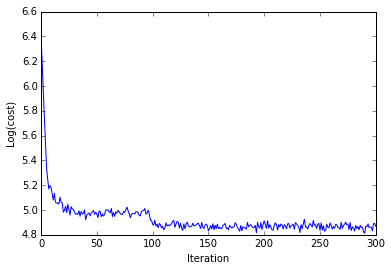

In [13]:
plt.plot(np.log(np.array(cost_list)))
plt.xlabel('Iteration')
plt.ylabel('Log(cost)')

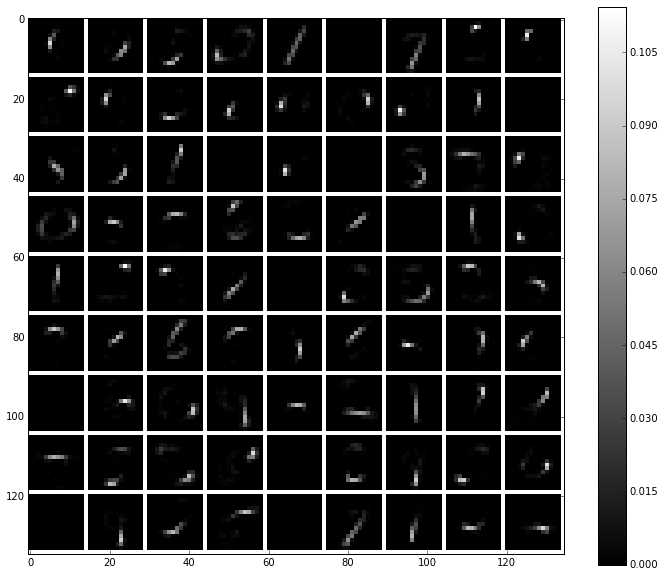

In [14]:
plt.figure(figsize=(12,10))
show_fields(t_D.get_value(), cmap = plt.cm.gray, pos_only = True)
#plt.savefig(output_dir + 'mnist_basis.png', dpi = 200)

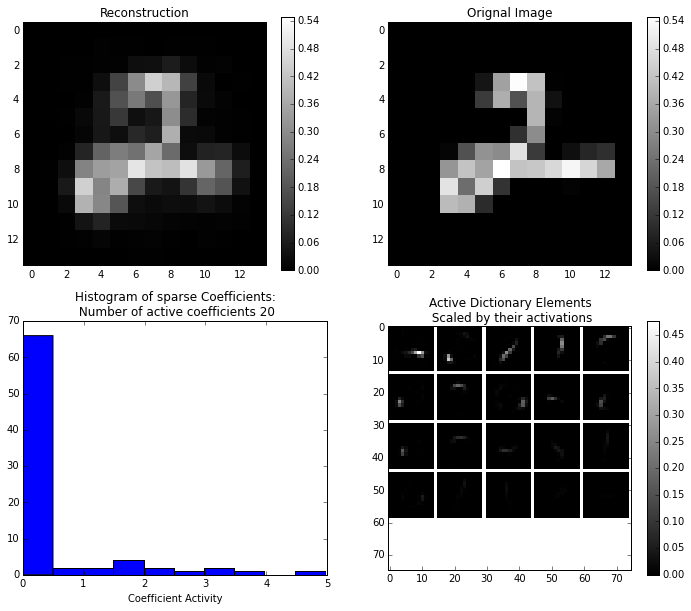

In [15]:
plt.figure(figsize=(12, 10))
q = np.random.randint(N_bat)
plt.subplot(2, 2, 1)
plt.title('Reconstruction')
plt.imshow(np.dot(t_A.get_value(), t_D.get_value())[q].reshape(L_pat, L_pat),
           interpolation = 'nearest',
           cmap = plt.cm.gray, vmin = 0, vmax = t_I.get_value()[I_idx][q].reshape(L_pat, L_pat).max())
plt.colorbar()
plt.subplot(2, 2, 2)
plt.title('Orignal Image')
plt.imshow(t_I.get_value()[I_idx][q].reshape(L_pat, L_pat),
           interpolation = 'nearest',
           cmap = plt.cm.gray)
plt.colorbar()
plt.subplot(2, 2, 3)

plt.hist(t_A.get_value()[q])

sort_idx = np.argsort(t_A.get_value()[q])[::-1]
N_active = np.sum(t_A.get_value()[q] > 0.0)
active_idx = sort_idx[0:N_active]

plt.title('Histogram of sparse Coefficients: \n Number of active coefficients %d' % N_active)
plt.xlabel('Coefficient Activity')

plt.subplot(2, 2, 4)
show_fields(t_D.get_value()[active_idx] * 
            t_A.get_value()[q][active_idx][:, np.newaxis], 
            cmap = plt.cm.gray, pos_only = True)
plt.title('Active Dictionary Elements \n Scaled by their activations')

((array([  1.58361248e-04,   3.84437539e-04,   6.12999434e-04, ...,
           7.39745303e+00,   7.86392144e+00,   8.75071094e+00]),
  array([  4.46395279e-05,   2.47256074e-04,   4.18521551e-04, ...,
           9.63031673e+00,   9.71194077e+00,   1.02431746e+01], dtype=float32)),
 (1.326627418885548, 0.20406783070266821, 0.99105614453520563))

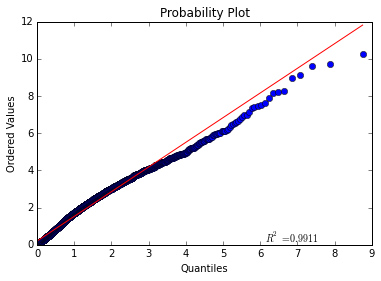

In [16]:
As = t_A.get_value().ravel()
probplot(As[As > 0], dist = expon, plot = plt)

Details on FISTA:

Since the objective function has an absolute value, typical gradient descent approaches converge slowly. Thus there are special purpose gradient descent methods that minimize functions that are in the form $$f(x) + g(x)$$ where $f(x)$ is a continuously differentiable, convex function and $g(x)$ is a convex, but not continuously differentiable function, such as $g(x) = \alpha |x|$. One such method is called FISTA, or the Fast Iterative Shrinkage-Threshold Algorithm. 

The core kernel of the FISTA algorithm is the ISTA step:

Define
$$p_L(y) = \text{argmin}_x \, g(x) + L/2 * ||x- g(y)||^2$$ where $$g(y) = y - \frac{1}{L} \nabla f(y)$$

and where $L$ is the constant such that $$||\nabla f(x) - \nabla f(y)|| \le L ||x - y||$$

When $g(x) = \alpha|x|_1$, then $$p_L(y) = h_\theta(y)\qquad h_\theta(y) = \text{sign}(y)(|y|-\theta)\qquad \theta = \frac{\alpha}{L}$$
$h$ is applied pointwise to $y$ and is the shrinkage function. Simplying calculating $x_{t+1} = p_L(x_t)$ is the ISTA algorithm. If we more intelligently choose our new value to probe our function, then we get faster convergence. The FISTA algorithm is as follows:

1. Initialize $y_0 = x_0 = X0$, $t_0=1$. 

2. For $k \ge 0$, iterate the following:

$$x_{k+1} = p_L(y_k)\qquad t_{k+1} = 0.5 * (1 + \sqrt{1 + 4 * t_k ^2})\qquad y_{k+1} = x_{k+1} + \frac{t_k - 1}{t_{k+1}} * (x_{k+1} - x_k)$$

In [30]:
#savemat(output_dir + 'mnist_dictionary.mat', 
#        {'D': t_D.get_value(), 'Alpha': Alpha,
#         'Algorithm': 'FISTA', 'Normalization': 'Equal Standard Deviation'})